In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tvt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import pickle

seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def arrangeDataPolyU(file_path = '/content/drive/MyDrive/Final_Report/data/PolyU-Real-World-Noisy-Images-Dataset-master/CroppedImages', train_ratio=0.8):

    print('Arranging the PolyU images')
    overall_set = []
    file_list = sorted(os.listdir(file_path))
    for i in range(0,len(file_list)-2,2):
        overall_set.append((file_list[i], file_list[i+1]))
    random.shuffle(overall_set)
    index = int(len(overall_set)*train_ratio)
    train_files = overall_set[:index+1]
    test_files = overall_set[index+1: ]
    training_data = {"noisy":[], "gt":[]}
    testing_data = {"noisy":[], "gt": []}

    print('Creating training data')
    for i in range(len(train_files)):
        img = Image.open(os.path.join(file_path, train_files[i][1]))
        training_data['gt'].append(Image.open(os.path.join(file_path, train_files[i][1])).convert('RGB').resize((256,256)))
        training_data['noisy'].append(Image.open(os.path.join(file_path, train_files[i][0])).convert('RGB').resize((256,256)))
    print("Number of ground truth images:",len(training_data['gt']))
    print("Number of noisy images:",len(training_data['noisy']))

    print('Creating testing data')
    for i in range(len(test_files)):
        testing_data['gt'].append(Image.open(os.path.join(file_path, test_files[i][1])).convert('RGB').resize((256,256)))
        testing_data['noisy'].append(Image.open(os.path.join(file_path, test_files[i][0])).convert('RGB').resize((256,256)))
    print("Number of ground truth images:",len(testing_data['gt']))
    print("Number of noisy images:",len(testing_data['noisy']))

    with open('/content/drive/MyDrive/Final_Report/data_polyu.pkl','wb') as f:
        pickle.dump((training_data, testing_data), f, protocol=pickle.HIGHEST_PROTOCOL)
    print('Pickle File Created for PolyU Images')

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data):
        super(ImageDataset, self).__init__()
        self.noisyData = data['noisy']
        self.gtData = data['gt']
        self.transform = tvt.Compose([tvt.ToTensor()])

    def __len__(self):
        return len(self.noisyData)

    def __getitem__(self, index):
        return self.transform(self.noisyData[index]), self.transform(self.gtData[index])

In [5]:
def createDataLoaders():
    if not os.path.isfile('/content/drive/MyDrive/Final_Report/data_polyu.pkl'):
        arrangeDataPolyU()
    with open('/content/drive/MyDrive/Final_Report/data_polyu.pkl', 'rb') as f:
        data = pickle.load(f)
    train_dataset = ImageDataset(data[0])
    test_dataset = ImageDataset(data[1])
    train_DL = DataLoader(train_dataset, batch_size=4, num_workers=4, shuffle=True)
    test_DL = DataLoader(test_dataset, batch_size=4, num_workers=4, shuffle=False)
    return train_DL, test_DL, train_dataset, test_dataset

In [6]:
class dCNN(torch.nn.Module):
    def __init__(self, channels, layers=20):
        super(dCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=channels, out_channels=64, kernel_size=3, padding=1, bias=False
        )
        self.convList = torch.nn.ModuleList()
        for i in range(layers - 2):
            self.convList.append(
                torch.nn.Conv2d(
                    in_channels=64,
                    out_channels=64,
                    kernel_size=3,
                    padding=1,
                    bias=False,
                )
            )
            self.convList.append(torch.nn.BatchNorm2d(64))
            self.convList.append(torch.nn.ReLU(inplace=True))
        self.conv2 = torch.nn.Conv2d(
            in_channels=64, out_channels=channels, kernel_size=3, padding=1, bias=False
        )

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x, inplace=True)
        for conv in self.convList:
            x = conv(x)
        x = self.conv2(x)
        return x

In [7]:
# function to check PSNR(dB)/SSIM values of the resulted images
def calculate_metrics(image, original, data_range):
    image = image.data.cpu().numpy().astype(np.float32)
    original = original.data.cpu().numpy().astype(np.float32)
    psnr_value = 0
    ssim_value = 0
    for i in range(image.shape[0]):
        psnr_value += psnr(
            original[i, :, :, :], image[i, :, :, :], data_range=data_range
        )
        ssim_value += ssim(
            original[i, :, :, :],
            image[i, :, :, :],
            channel_axis=0,
            data_range=data_range,
        )
    psnr_value /= image.shape[0]
    ssim_value /= image.shape[0]

    return psnr_value, ssim_value

In [8]:
def im2patch(im, pch_size, stride=1):
    if isinstance(pch_size, tuple):
        pch_H, pch_W = pch_size
    elif isinstance(pch_size, int):
        pch_H = pch_W = pch_size

    if isinstance(stride, tuple):
        stride_H, stride_W = stride
    elif isinstance(stride, int):
        stride_H = stride_W = stride

    C, H, W = im.shape
    num_H = len(range(0, H-pch_H+1, stride_H))
    num_W = len(range(0, W-pch_W+1, stride_W))
    num_pch = num_H * num_W
    pch = torch.zeros((C, pch_H*pch_W, num_pch))
    kk = 0
    for ii in range(pch_H):
        for jj in range(pch_W):
            temp = im[:, ii:H-pch_H+ii+1:stride_H, jj:W-pch_W+jj+1:stride_W]
            pch[:, kk, :] = temp.reshape((C, num_pch))
            kk += 1

    return pch.reshape((C, pch_H, pch_W, num_pch))

def noise_estimate(im, pch_size=8):

    if im.ndim == 3:
        im = im.permute((0, 1, 2))
    else:
        im = torch.unsqueeze(im, axis=0)

    pch = im2patch(im, pch_size, 3)
    num_pch = pch.shape[3]
    pch = pch.reshape((-1, num_pch))
    d = pch.shape[0]

    mu = pch.mean(axis=1, keepdims=True)  # d x 1
    X = pch - mu
    sigma_X = torch.matmul(X, torch.transpose(X,0,1)) / num_pch
    sig_value, _ = torch.linalg.eigh(sigma_X)
    sig_value.sort()

    for ii in range(-1, -d-1, -1):
        tau = torch.mean(sig_value[:ii])
        if torch.sum(sig_value[:ii]>tau) == torch.sum(sig_value[:ii] < tau):
            if tau < 0:
                tau = 1
            return np.sqrt(tau)

In [26]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)


def sampleTesting(dataset, R2R_model, R2R_model_path, N2C_model, N2C_model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    R2R_model.load_state_dict(torch.load(R2R_model_path))
    N2C_model.load_state_dict(torch.load(N2C_model_path))
    R2R_model.eval()
    N2C_model.eval()
    idx = random.randint(0, len(dataset))
    noisy_image, clean_image = dataset[idx]
    noisy_image = noisy_image.to(device)
    clean_image = clean_image.to(device)
    input = torch.unsqueeze(noisy_image, 0).to(device)
    target = torch.unsqueeze(clean_image, 0).to(device)
    with torch.no_grad():
        R2R_output = R2R_model(input)
        N2C_output = N2C_model(input)
    R2R_out = torch.clamp(R2R_output, 0, 1)
    N2C_out = torch.clamp(N2C_output, 0, 1)
    psnr_val_R2R, ssim_value_R2R = calculate_metrics(R2R_out, target, data_range=1.0)
    psnr_val_N2C, ssim_value_N2C = calculate_metrics(N2C_out, target, data_range=1.0)
    fig,axes = plt.subplots(1,4, figsize=(50,10))
    #fig.tight_layout()
    noisy_PIL = tvt.ToPILImage()(noisy_image.squeeze().cpu())
    clean_PIL = tvt.ToPILImage()(clean_image.squeeze().cpu())
    R2R_out_PIL = tvt.ToPILImage()(R2R_out.squeeze().cpu())
    N2C_out_PIL = tvt.ToPILImage()(N2C_out.squeeze().cpu())
    axes[1].imshow(noisy_PIL)
    axes[1].set_title("Noisy Image", size=50)
    axes[0].imshow(clean_PIL)
    axes[0].set_title("Clean Image", size=50)
    axes[2].imshow(R2R_out_PIL)
    axes[2].set_title("R2R", size=50)
    axes[3].imshow(N2C_out_PIL)
    axes[3].set_title("N2C", size=50)
    format_axes(fig)

In [21]:
def testAlgorithms(model, dataset, model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    psnr_list = []
    ssim_list = []
    test_output = None
    for i in range(len(dataset)):
        noisy_image, clean_image = dataset[i]
        input = torch.unsqueeze(noisy_image, 0).to(device)
        target = torch.unsqueeze(clean_image, 0).to(device)
        with torch.no_grad():
            output = model(input)
        out = torch.clamp(output, 0, 1)
        psnr_val, ssim_value = calculate_metrics(out, target, data_range=1.0)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_value)
        del output
    print(
        "PSNR of testing dataset:",
        sum(psnr_list) / len(psnr_list),
        "SSIM of testing dataset:",
        sum(ssim_list) / len(ssim_list),
    )

In [10]:
def trainingR2R(model, device, dataloader, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.004)
    criterion = torch.nn.MSELoss()
    alpha = 25
    losses = []
    psnr_values = []
    ssim_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        psnr_value = 0.0
        ssim_value = 0.0
        for idx, data in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            noisy_image, clean_image = data
            sigma = torch.zeros(noisy_image.size()[0])
            for i in range(noisy_image.size()[0]):
              sigma[i] = noise_estimate(noisy_image[i])
            noisy_image = noisy_image.to(device)
            clean_image = clean_image.to(device)
            D_sc = torch.FloatTensor(noisy_image.size()).normal_(mean=0, std=1.0)
            D = torch.zeros(noisy_image.size())
            for i in range(noisy_image.size()[0]):
                D[i] = sigma[i] * D_sc[i]
            D = D.to(device)
            input = noisy_image + alpha * D
            target = noisy_image - D / alpha
            output = torch.clamp(model(input),0,1)
            loss = criterion(output, target)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # evaluating the performance per batch
            model.eval()
            sigma_test = noise_estimate(noisy_image[0])
            input = noisy_image + (torch.FloatTensor(noisy_image.size()).normal_(mean=0)*sigma_test).cuda()
            output = torch.clamp(model(input), 0, 1)
            psnr_val, ssim_value = calculate_metrics(output, clean_image, 1.0)
            psnr_value += psnr_val
            if idx != 0 and (idx+1) % 4 == 0:
                losses.append((running_loss / 4))
                psnr_values.append((psnr_value / 4))
                ssim_values.append((ssim_value/4))
                print(
                    "Epoch:",epoch + 1,
                    "[",idx + 1,"|",
                    len(dataloader),"]",
                    "=>",
                    "PSNR:",psnr_value / 4,
                    "SSIM",ssim_value / 4,
                    "Loss:",running_loss / 4,
                )
                running_loss = 0.0
                psnr_value = 0.0
                ssim_value = 0.0

            del noisy_image
            del clean_image
            del input
            del output
            del D

    # creating a plot and saving it
    fig, axes = plt.subplots(3,1)
    fig.tight_layout()

    axes[0].plot(losses)
    axes[0].title.set_text("R2R Training Loss")

    axes[1].plot(psnr_values)
    axes[1].title.set_text("R2R Training PSNR Values")

    axes[2].plot(ssim_values)
    axes[2].title.set_text("R2R Training SSIM Values")

    fig.savefig("/content/drive/MyDrive/Final_Report/"+"R2R_PolyU_TrainingResult.png")

    file_name = "/content/drive/MyDrive/Final_Report/" + "R2R_PolyU" + "_model_"  + ".pth"
    torch.save(model.state_dict(), file_name)

In [11]:
def trainingN2C(model, device, dataloader, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
    criterion = torch.nn.MSELoss()
    losses = []
    psnr_values = []
    ssim_values = []
    for epoch in range(epochs):
        running_loss = 0.0
        psnr_value = 0.0
        ssim_value = 0.0
        for idx, data in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            noisy_image, clean_image = data
            noisy_image = noisy_image.to(device)
            clean_image = clean_image.to(device)
            input = noisy_image
            target = clean_image
            output = torch.clamp(model(input),0,1)
            loss = criterion(output, target)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            # evaluating the performance per batch
            model.eval()
            output = torch.clamp(model(noisy_image), 0, 1)
            psnr_val, ssim_value = calculate_metrics(output, clean_image, 1.0)
            psnr_value += psnr_val
            if idx != 0 and (idx+1) % 4 == 0:
                losses.append((running_loss / 4))
                psnr_values.append((psnr_value / 4))
                ssim_values.append((ssim_value/4))
                print(
                    "Epoch:",epoch + 1,
                    "[",idx + 1,"|",
                    len(dataloader),"]",
                    "=>",
                    "PSNR:",psnr_value / 4,
                    "SSIM",ssim_value / 4,
                    "Loss:",running_loss / 4,
                )
                running_loss = 0.0
                psnr_value = 0.0
                ssim_value = 0.0

            del noisy_image
            del clean_image

    # creating a plot and saving it
    fig, axes = plt.subplots(3,1)
    fig.tight_layout()

    axes[0].plot(losses)
    axes[0].title.set_text("N2C Training Loss")

    axes[1].plot(psnr_values)
    axes[1].title.set_text("N2C Training PSNR Values")

    axes[2].plot(ssim_values)
    axes[2].title.set_text("N2C Training SSIM Values")

    fig.savefig("/content/drive/MyDrive/Final_Report/"+"N2C_PolyU_TrainingResult.png")
    file_name = "/content/drive/MyDrive/Final_Report/" + "N2C_PolyU" + "_model_" + ".pth"

    file_name = "/content/drive/MyDrive/Final_Report/" + "N2C_PolyU" + "_model_" + ".pth"
    torch.save(model.state_dict(), file_name)

In [12]:
# Main Pipeline using PolyU Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainDL, testDL, trainDataset, testDataset = createDataLoaders()
model_R2R = dCNN(channels=3)
model_N2C = dCNN(channels=3)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Streaming output truncated to the last 5000 lines.
Epoch: 1001 [ 4 | 20 ] => PSNR: 16.591369573396626 SSIM 0.16702543012797832 Loss: 0.0029920788074377924
Epoch: 1001 [ 8 | 20 ] => PSNR: 17.79721647813988 SSIM 0.18765141814947128 Loss: 0.003781159728532657
Epoch: 1001 [ 12 | 20 ] => PSNR: 19.10074977244918 SSIM 0.19117096439003944 Loss: 0.003230322152376175
Epoch: 1001 [ 16 | 20 ] => PSNR: 20.73399773232728 SSIM 0.20001699030399323 Loss: 0.0027603450580500066
Epoch: 1001 [ 20 | 20 ] => PSNR: 21.695467721613497 SSIM 0.19101811945438385 Loss: 0.002021818479988724
Epoch: 1002 [ 4 | 20 ] => PSNR: 20.103112829717862 SSIM 0.18603910878300667 Loss: 0.0017822249210439622
Epoch: 1002 [ 8 | 20 ] => PSNR: 17.590098233631757 SSIM 0.18028755113482475 Loss: 0.0030572150135412812
Epoch: 1002 [ 12 | 20 ] => PSNR: 16.77453946141223 SSIM 0.1836932711303234 Loss: 0.002228464843938127
Epoch: 1002 [ 16 | 20 ] => PSNR: 20.600457473780132 SSIM 0.19385895505547523 Loss: 0.004335231438744813
Epoch: 1002 [ 20 |

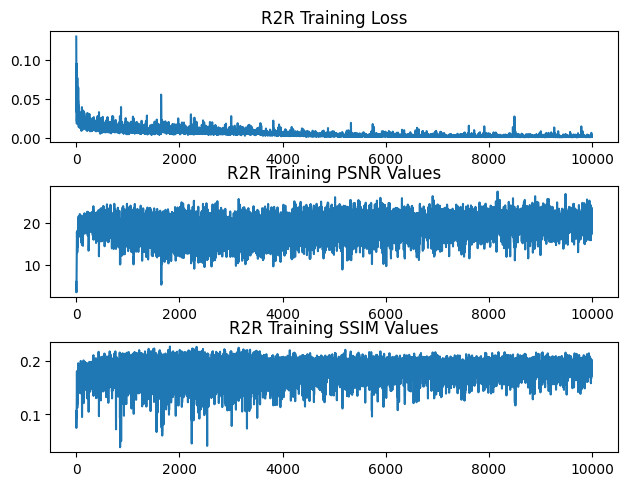

In [14]:
trainingR2R(model_R2R, device, trainDL, 2000)

Streaming output truncated to the last 5000 lines.
Epoch: 1001 [ 4 | 20 ] => PSNR: 22.97151614888182 SSIM 0.21104870736598969 Loss: 0.002355152420932427
Epoch: 1001 [ 8 | 20 ] => PSNR: 22.91360840388715 SSIM 0.20613403618335724 Loss: 0.002764634438790381
Epoch: 1001 [ 12 | 20 ] => PSNR: 25.16240153851952 SSIM 0.22288455441594124 Loss: 0.0025282151764258742
Epoch: 1001 [ 16 | 20 ] => PSNR: 25.64832623256661 SSIM 0.2218293584883213 Loss: 0.00192576514382381
Epoch: 1001 [ 20 | 20 ] => PSNR: 27.761262551930646 SSIM 0.22144057229161263 Loss: 0.0016790817026048899
Epoch: 1002 [ 4 | 20 ] => PSNR: 26.955938598016004 SSIM 0.20738860964775085 Loss: 0.0015910438232822344
Epoch: 1002 [ 8 | 20 ] => PSNR: 23.50603721606599 SSIM 0.21132205799221992 Loss: 0.002648561232490465
Epoch: 1002 [ 12 | 20 ] => PSNR: 24.42235829348647 SSIM 0.21592332422733307 Loss: 0.003363639727467671
Epoch: 1002 [ 16 | 20 ] => PSNR: 24.469266674226233 SSIM 0.2179843783378601 Loss: 0.006668788933893666
Epoch: 1002 [ 20 | 20 ]

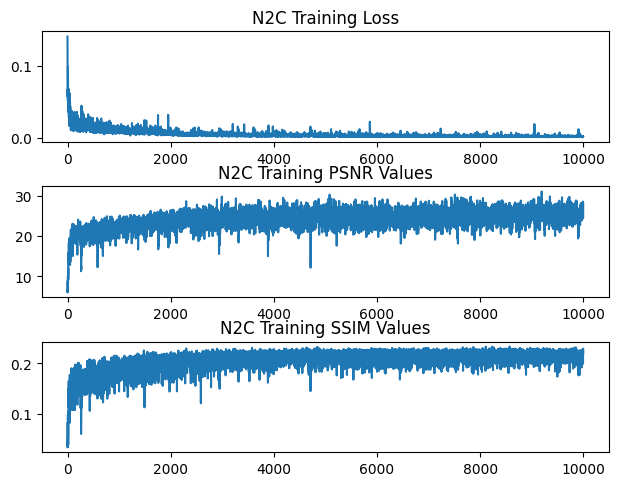

In [15]:
trainingN2C(model_N2C, device, trainDL, 2000)

In [22]:
testAlgorithms(model_R2R, testDataset, "/content/drive/MyDrive/Final_Report/R2R_PolyU_model_.pth")

PSNR of testing dataset: 18.58742543509845 SSIM of testing dataset: 0.7307857933797335


In [23]:
testAlgorithms(model_N2C, testDataset, "/content/drive/MyDrive/Final_Report/N2C_PolyU_model_.pth")

PSNR of testing dataset: 26.931416999055138 SSIM of testing dataset: 0.8831503234411541


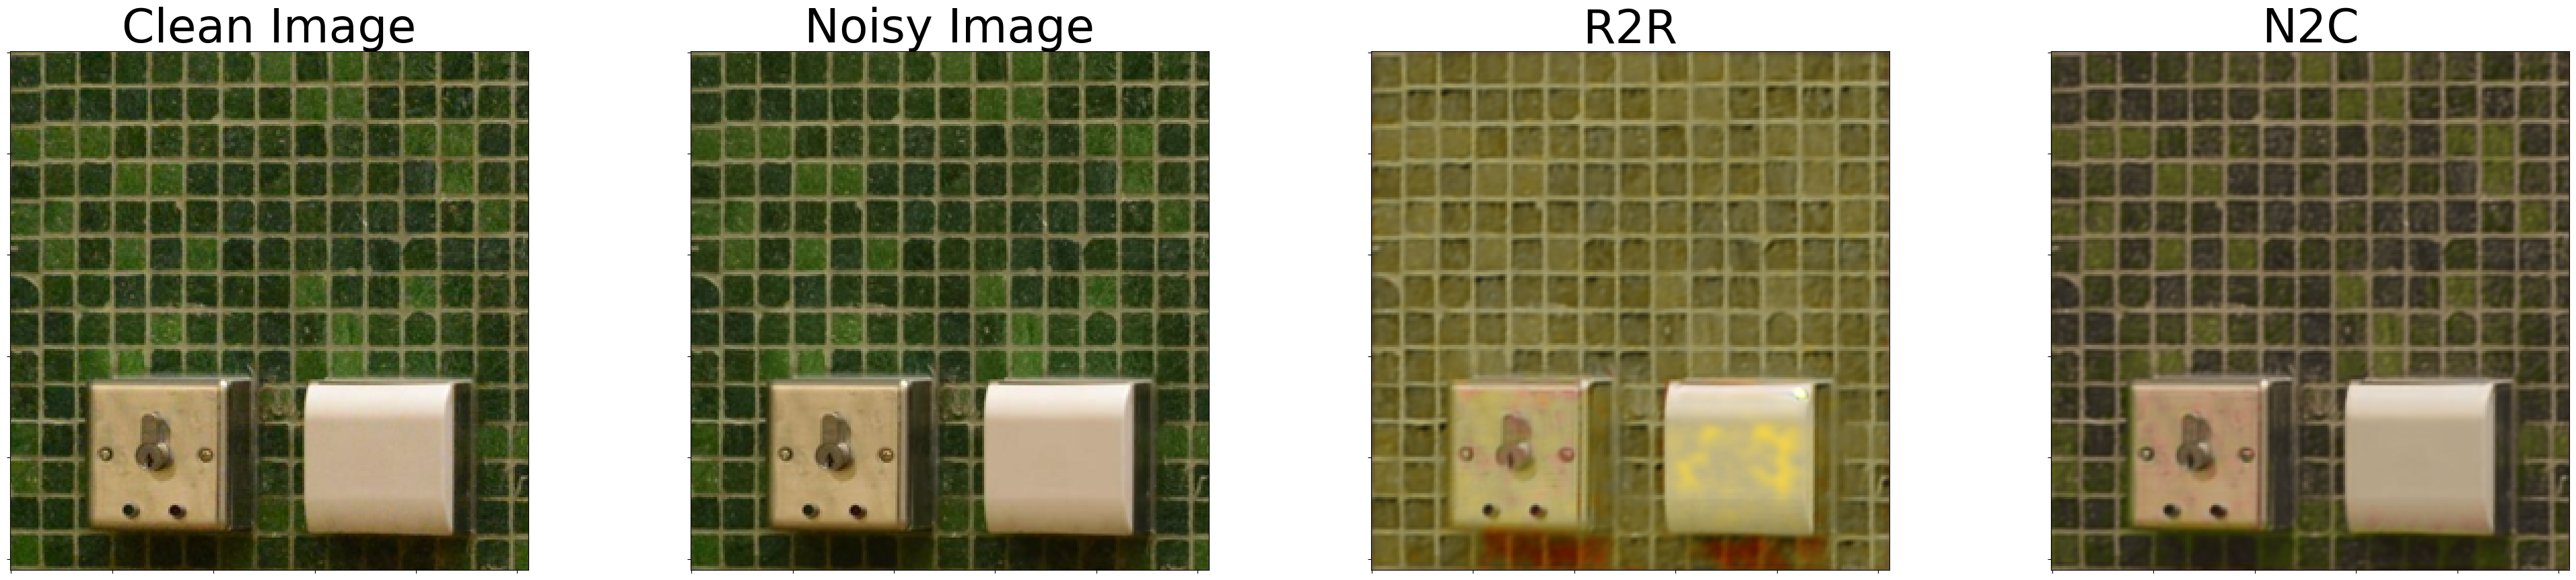

In [27]:
sampleTesting(testDataset, model_R2R, "/content/drive/MyDrive/Final_Report/R2R_PolyU_model_.pth",  model_N2C, "/content/drive/MyDrive/Final_Report/N2C_PolyU_model_.pth")